In [1]:
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_prices


EPSILON = 1e-10
RETURN_SCALE = 100

# if __name__ == "__main__":

start_time = '1574812800'
end_time = '1580774400'

# df_ = get_prices(
#     'btc', 'usdt',
#     datetime(2019, 11, 27),
#     duration=timedelta(days=69),
#     proxy_port='8815',
#     verbose=2)

df_ = pd.read_csv('data/BTCUSDT[' + start_time + '000_' + end_time + '000].csv')
df_.drop(['Unnamed: 0'], inplace=True, axis=1)
df_['Time'] = pd.to_datetime(df_['Time'])
df_.set_index('Time', inplace=True, drop=True)

times_index = pd.date_range(
    start=pd.to_datetime(start_time, unit='s'),
    end=pd.to_datetime(end_time, unit='s'),
    periods=(int(end_time) - int(start_time) + 1) / 60 + 1)

df = pd.DataFrame(None, columns=df_.columns, index=times_index[:-1])

selected_indices = list(set(df_.index).intersection(set(times_index)))
df.loc[selected_indices, df_.columns] = df_.loc[selected_indices].copy()
df

,Market,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value
2019-11-27 00:00:00,BTCUSDT,7154.75,7157.17,7140.93,7143.75,50.60209,361769.135911,385,25.821743,184606.826394
2019-11-27 00:01:00,BTCUSDT,7143.68,7147.86,7140.54,7145.65,23.730561,169533.383641,222,16.156826,115429.347803
2019-11-27 00:02:00,BTCUSDT,7144.64,7153.89,7144.63,7151.6,19.483032,139284.673628,180,14.570335,104167.055035
2019-11-27 00:03:00,BTCUSDT,7152.05,7153.89,7148.79,7151.31,24.30841,173835.703832,157,9.768423,69859.228982
2019-11-27 00:04:00,BTCUSDT,7152.07,7164.59,7150.99,7162.89,46.076171,329899.961909,290,37.453687,268154.818917
...,...,...,...,...,...,...,...,...,...,...
2020-02-03 23:55:00,BTCUSDT,9307.21,9307.73,9299.21,9299.22,21.421539,199333.709068,222,9.042252,84149.16618
2020-02-03 23:56:00,BTCUSDT,9299.28,9305.88,9298.32,9303.07,22.548824,209730.383157,205,17.150674,159517.416949
2020-02-03 23:57:00,BTCUSDT,9303.1,9303.58,9300.04,9301.45,13.845829,128797.438535,218,5.10378,47477.145602
2020-02-03 23:58:00,BTCUSDT,9302.13,9307.02,9301.28,9303.42,13.548862,126055.88925,183,8.918618,82976.801269


In [2]:
timeframe = timedelta(minutes=5)

df = df.resample(timeframe).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'Value': 'sum',
    'No. Trades': 'sum',
    'Taker Buy Volume': 'sum',
    'Taker Buy Value': 'sum'
})
df['Average Price'] = df['Value'] / df['Volume']
df['Average Price Change'] = df['Average Price'].pct_change()
df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Average Price,Average Price Change
2019-11-27 00:00:00,7154.75,7164.59,7140.54,7162.89,164.200264,1174322.858921,1234,103.771014,742217.277131,7151.772051,NaN
2019-11-27 00:05:00,7164.4,7169.00,7152.92,7157.86,115.531698,827553.413765,904,73.404774,525826.737982,7162.998797,0.001570
2019-11-27 00:10:00,7157.32,7160.19,7144.93,7151.68,112.780186,806537.314318,914,57.210353,409185.53799,7151.409684,-0.001618
2019-11-27 00:15:00,7152.16,7152.20,7138.93,7142.66,157.903923,1128196.518585,833,70.53854,503984.524916,7144.828939,-0.000920
2019-11-27 00:20:00,7142.63,7148.81,7138.94,7146.63,71.999481,514385.20938,638,42.162902,301241.148857,7144.290518,-0.000075
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-03 23:35:00,9298.38,9300.35,9277.07,9294.66,148.543688,1379949.554079,1348,82.834562,769549.767916,9289.856558,-0.000593
2020-02-03 23:40:00,9294.66,9307.69,9294.01,9304.29,90.220836,839207.947381,908,64.413847,599153.526012,9301.708836,0.001276
2020-02-03 23:45:00,9304.0,9319.99,9295.98,9316.82,139.875918,1301847.098326,1874,68.115588,633991.892739,9307.156778,0.000586
2020-02-03 23:50:00,9316.15,9316.88,9303.73,9306.52,95.824739,892149.993958,1331,45.580965,424366.578549,9310.226182,0.000330


In [4]:
features = pd.DataFrame(index=df.index)
features['taker buy portion'] = df['Taker Buy Volume'] / (df['Volume'] + EPSILON)
features['volume change'] = (df['Volume'] + EPSILON).pct_change()
#
# a = df['Taker Buy Value'] / (df['Taker Buy Volume'] + EPSILON)
#
# b = (df['Value'] - df['Taker Buy Value']) / (df['Volume'] - df['Taker Buy Volume'] + EPSILON)
# df['Feature 3'] = (a - b) / df['Open'] * RETURN_SCALE * 100
#
# def historical_high_to_low_ratio(window):
#     tmp = df['High'].rolling(window).max()
#     return (tmp-df['Close']) / (tmp-df['Low'].rolling(window).min() + EPSILON) * 100
#
# for i, t in enumerate([1, 6, 24]):
#     window = int(timedelta(hours=t) / timeframe)
#     df[f'Feature {4+i}'] = historical_high_to_low_ratio(window)
#
# period = 10
# for i in range(period):
#     df[f'Return {i+1} min'] = (df['Close'].shift(-i-1) / df['Close'] - 1) * 100
features

,taker buy portion,volume change
2019-11-27 00:00:00,0.631978,NaN
2019-11-27 00:05:00,0.635365,-0.296398
2019-11-27 00:10:00,0.507273,-0.023816
2019-11-27 00:15:00,0.446718,0.400103
2019-11-27 00:20:00,0.5856,-0.544030
...,...,...
2020-02-03 23:35:00,0.557644,1.582849
2020-02-03 23:40:00,0.713958,-0.392631
2020-02-03 23:45:00,0.486972,0.550373
2020-02-03 23:50:00,0.47567,-0.314930


In [5]:
# returns = df['Close'].pct_change() * 100 * RETURN_SCALE
# returns[0] = (df.iloc[0]['Close'] / df.iloc[0]['Open'] - 1) * 100 * RETURN_SCALE
# df['Return'] = returns
# df

In [6]:
# m = 100
# plt.figure(figsize=(20, 10))
# plt.xticks(rotation=90)
# plt.plot(
#     df.iloc[0:m].index,
#     df['Weighted Price Average'][0:m],
#     color='black')
# x_limits = plt.xlim()
# x_width = x_limits[1] - x_limits[0]
# plt.bar(
#     x=df.iloc[0:m].index,
#     height=df['Close'].shift(1)[0:m]-df['Weighted Price Average'][0:m],
#     width=0.1*(x_width / m),
#     bottom=df['Weighted Price Average'][0:m],
#     color='red')
# plt.scatter(
#     df.iloc[0:m].index,
#     df['Close'].shift(1)[0:m],
#     color='red'
# )
# plt.show()

In [7]:
# real_return = df['Weighted Price Average'].pct_change() * 100 * RETURN_SCALE
# real_return[0] = (df.iloc[0]['Weighted Price Average'] / df.iloc[0]['Open'] - 1) * 100 * RETURN_SCALE
# df['Real Return'] = real_return
# df

In [8]:
# from scipy.stats import pearsonr
# tmp = [(1., 0), ]
# for i in range(360):
#     if i == 0:
#         x = (df['Average Price'].shift(-1) / df['Average Price'] - 1) * 100 * RETURN_SCALE
#     else:
#         y = (df['Average Price'].shift(-i-1) / df['Average Price'] - 1) * 100 * RETURN_SCALE
#         intersection = sorted(list(set(x.dropna().index).intersection(set(y.dropna().index))))
#         tmp.append(pearsonr(x.loc[intersection], y.loc[intersection]))
# tmp = np.array(tmp)

In [9]:
# %matplotlib inline
# plt.figure(figsize=(10, 3), dpi=120)
# plt.plot(np.log2(tmp[:, 0]))
# plt.title('BTC Price Change Memory')
# txt = "correlation diagram (in binary logarithmic scale) of BTC price return with cummulative price return up to some future point"
# plt.gcf().text(0.5, -0.1, txt, wrap=False, horizontalalignment='center', fontsize=8)
# plt.xlabel('time elapsed (minutes)')
# plt.ylabel('correlation (logarithmic)')
# plt.xticks(np.arange(25) * 15, fontsize=5)
# plt.yticks(np.arange(0, -5, -1))
# plt.grid()
# for i in range(-1, -5, -1):
#     point = np.where(np.log2(tmp[:, 0]) >= i)[0][-1]
#     plt.scatter(point, np.log2(tmp[point, 0]), marker='x', label=str(point))
# plt.legend()
# plt.savefig("Correlation.png")
# plt.show()

In [206]:
m = 15
r = len(features.columns)

X = pd.DataFrame(index=df.index)
for i in range(m):
    X[f'Average Price Change from last {i} candle so far'] = \
        df['Average Price'].pct_change(1 if i == 0 else i).shift(-1 if i == 0 else 0)

period_start = datetime(2019, 12, 1)
period_start_iloc = np.where(df.index == period_start)[0][0]
period_end = datetime(2020, 2, 1)
period_end_iloc = np.where(df.index == period_end)[0][0]

for k in np.arange(1, 16)*64 + 63:
    THETA = []
    results = pd.DataFrame(index=df.index)
    results['Prediction'] = None
    results['Measurement'] = None
    results['Model Noise Bias'] = None
    for n in np.arange(period_start_iloc, period_end_iloc):
        A = np.zeros([k, m])
        A[:, range(m)] = X.iloc[(n-2)-(k-1):(n-2)+1].to_numpy()
        b = X.iloc[(n-1)-(k-1):(n-1)+1, 0].values
        theta, _, _, _ = np.linalg.lstsq(A, b, rcond=-1)
        THETA.append(theta)
        pos = results.index[n]
        results.loc[pos, 'Model Noise Bias'] = (np.dot(A, theta) - b).mean()
        results.loc[pos, 'Prediction'] = np.dot(theta, X.iloc[n-1].values) + results.loc[pos, 'Model Noise Bias']
        results.loc[pos, 'Measurement'] = df.iloc[n]['Open'] / df.iloc[n-1]['Average Price'] - 1

    indices = df.index[period_start_iloc:period_end_iloc]
    results = results.loc[indices]
    results['Reality'] = df['Average Price Change'].shift(-1).loc[indices].values
    THETA = pd.DataFrame(THETA, index=indices)
    pd.concat([results, THETA], axis=1).to_csv(f'data/linear_model_without_control[k={k},m={m}]')

    t = np.bincount(np.sign(results['Prediction']) == np.sign(results['Reality']))
    print(t[1] / (t[0]+t[1]) * 100)
    print('STANDARD ERRORS')
    for c_label in ['Prediction', 'Measurement']:
        print('  > {:13s}{:.5f}'.format(c_label + ':', (results[c_label] - results['Reality']).std()))
    print('  > {:13s}{:.5f}'.format('Reality:', (results['Reality']-df['Average Price Change'].loc[indices].values).std()))

51.204077060931894
STANDARD ERRORS
  > Prediction:  0.00160
  > Measurement: 0.00171
  > Reality:     0.00186
51.388888888888886
STANDARD ERRORS
  > Prediction:  0.00152
  > Measurement: 0.00171
  > Reality:     0.00186
51.4616935483871
STANDARD ERRORS
  > Prediction:  0.00149
  > Measurement: 0.00171
  > Reality:     0.00186
51.9489247311828
STANDARD ERRORS
  > Prediction:  0.00147
  > Measurement: 0.00171
  > Reality:     0.00186
52.32974910394266
STANDARD ERRORS
  > Prediction:  0.00146
  > Measurement: 0.00171
  > Reality:     0.00186
52.37455197132617
STANDARD ERRORS
  > Prediction:  0.00145
  > Measurement: 0.00171
  > Reality:     0.00186
52.2793458781362
STANDARD ERRORS
  > Prediction:  0.00145
  > Measurement: 0.00171
  > Reality:     0.00186
52.53136200716846
STANDARD ERRORS
  > Prediction:  0.00145
  > Measurement: 0.00171
  > Reality:     0.00186
52.96818996415771
STANDARD ERRORS
  > Prediction:  0.00144
  > Measurement: 0.00171
  > Reality:     0.00186
52.716173835125446
S

In [57]:
stds = [[], []]
results = None
for i, m in enumerate([15, 60]):
    for k in np.arange(1, 16)*64 + 63:
        results = pd.read_csv(f'data/linear_model_without_control[k={k},m={m}]')
        tmp = results['Prediction'].astype(float) - results['Reality'].astype(float)
        stds[i].append(tmp.std())
stds

[[0.0015961022022403016,
  0.00152055387627442,
  0.0014891723680935131,
  0.0014727795428904377,
  0.001461830762716469,
  0.00145471515414208,
  0.0014525953371391836,
  0.0014480900554654477,
  0.001444216566864636,
  0.001441254673557843,
  0.0014375011702751433,
  0.0014352648846379914,
  0.0014334323373023834,
  0.00143169101433878,
  0.0014300717592828688],
 [0.002239009735230206,
  0.0018150292736429992,
  0.0016786120506296987,
  0.0016169973993114244,
  0.0015769981805352053,
  0.0015522183869227913,
  0.0015365933952790542,
  0.001521460448366684,
  0.0015102461163682085,
  0.0015007903553232312,
  0.0014920355813577949,
  0.0014856938239016675,
  0.0014807937385189931,
  0.0014754652942756497,
  0.001470876203494117]]

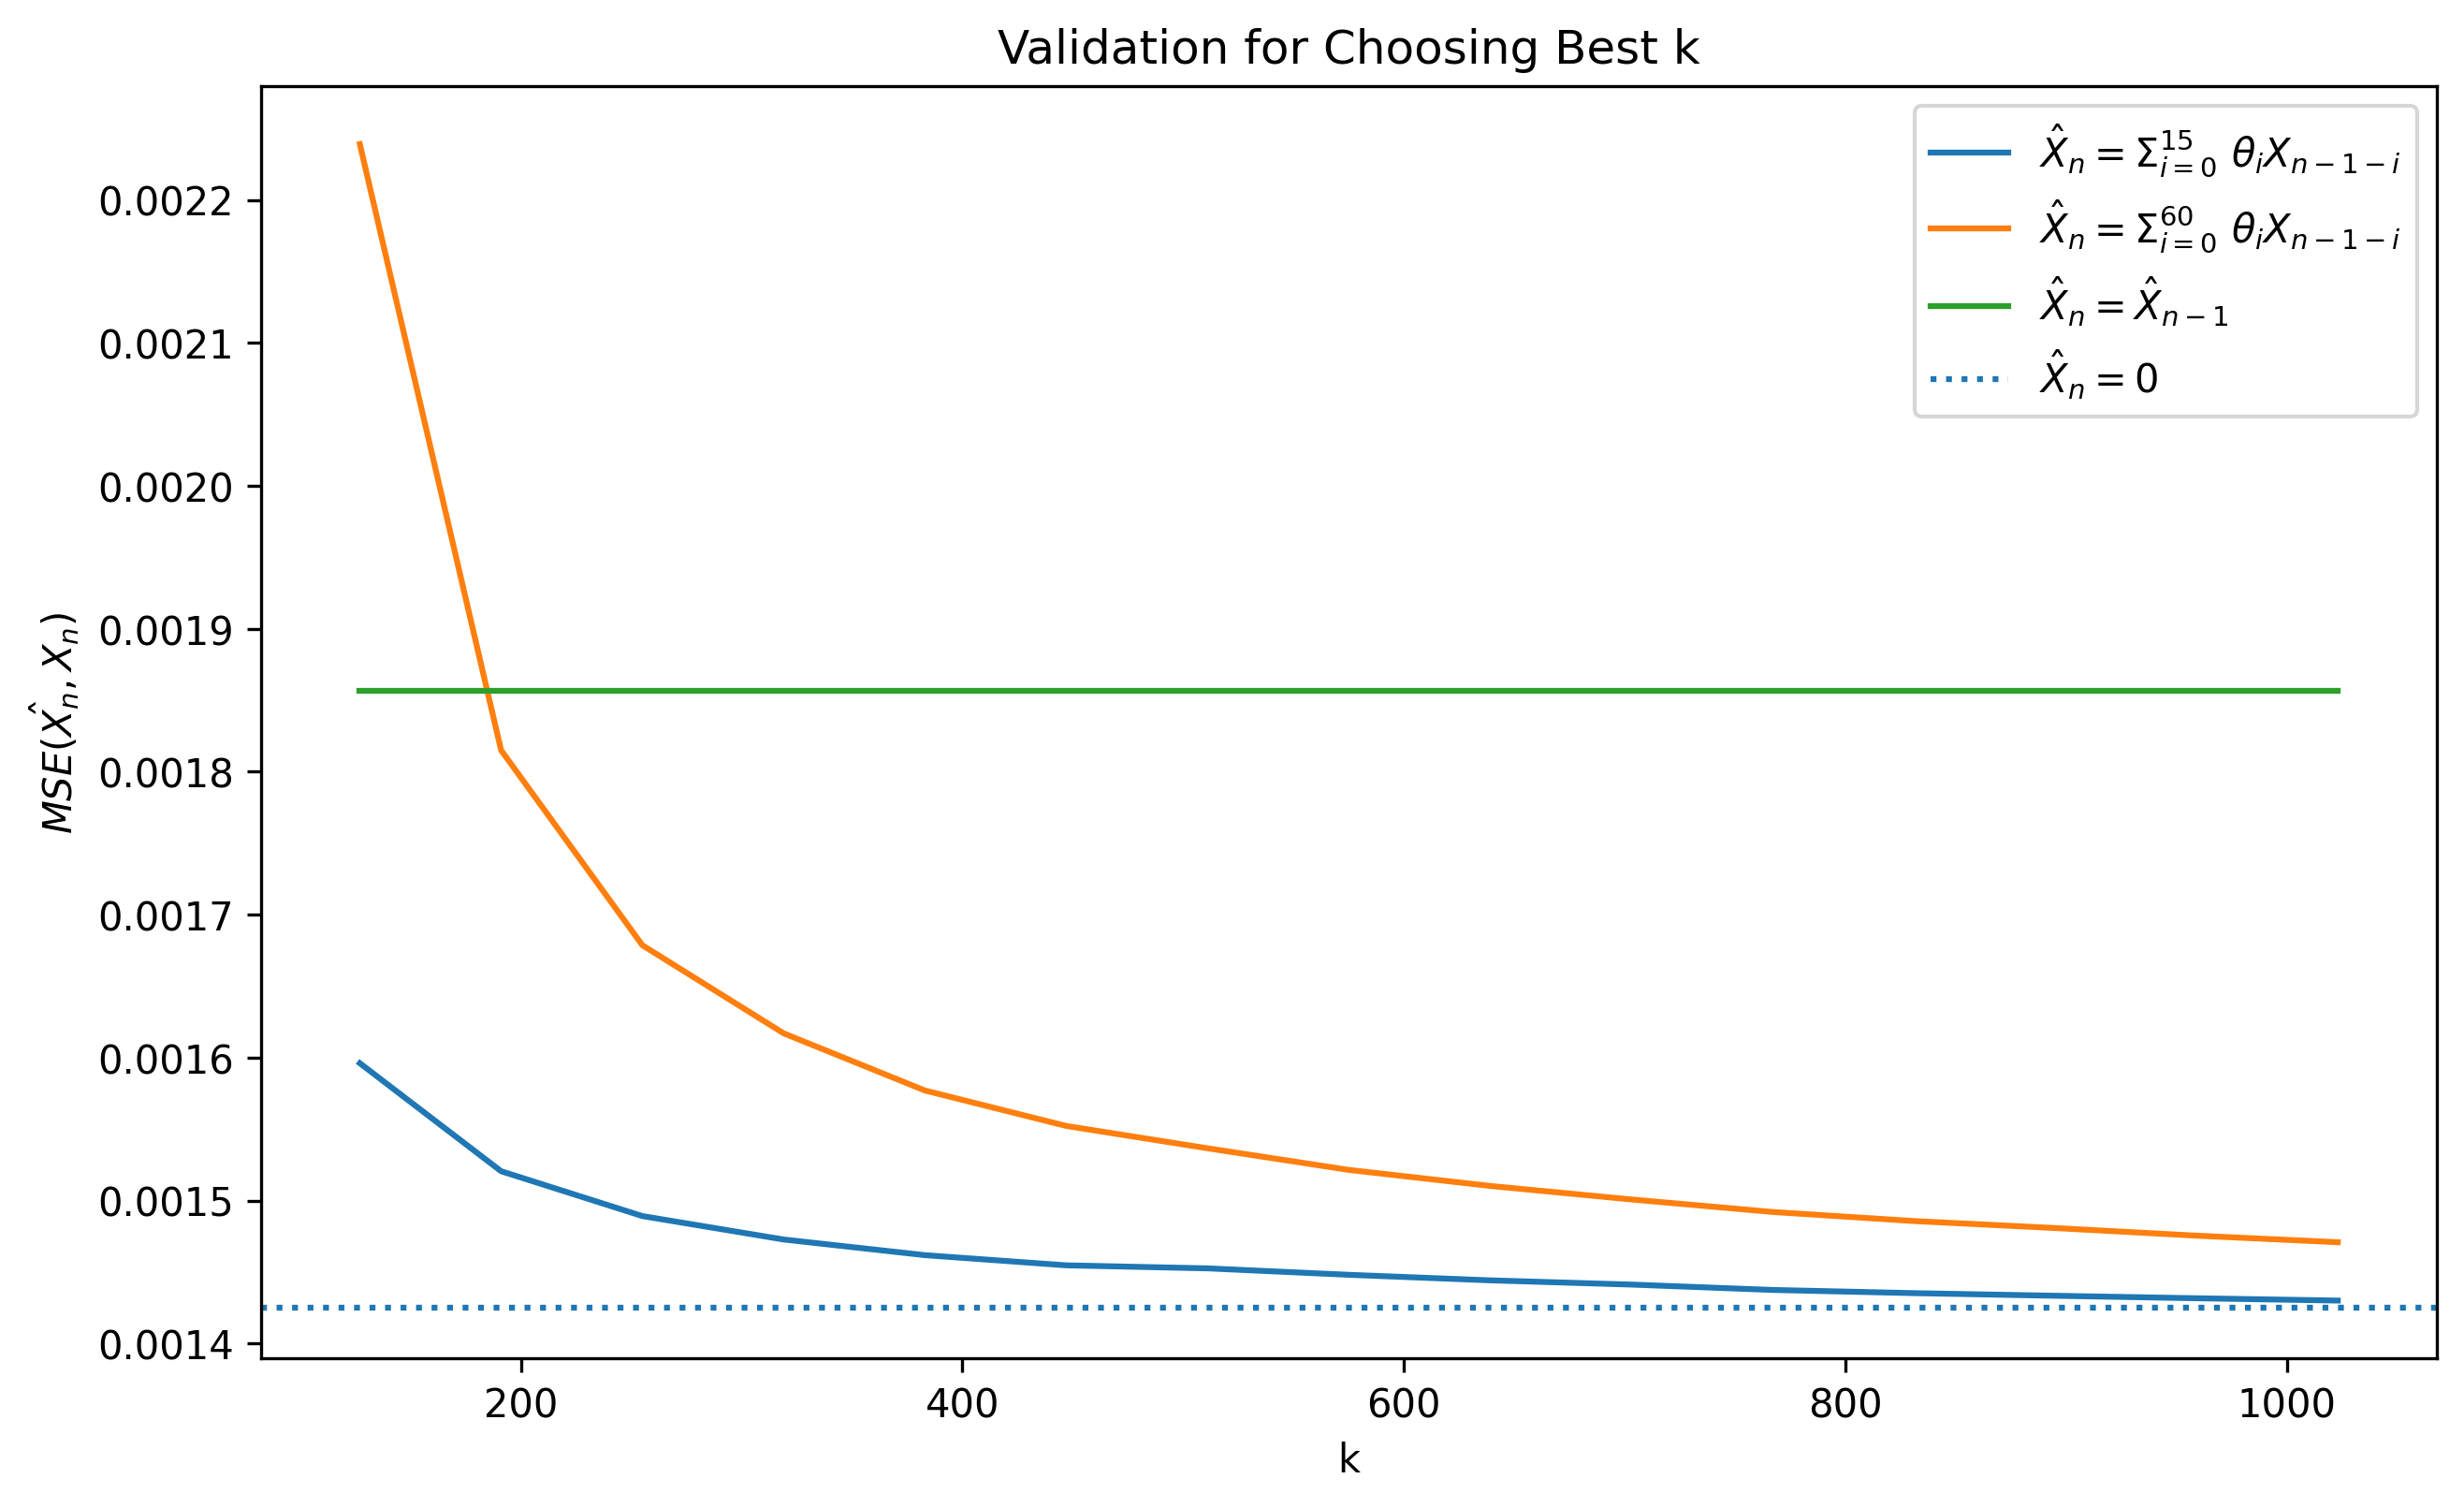

In [62]:
plt.figure(figsize=(10, 6), dpi=300)

plt.plot(range(127, 1087, 64), stds[0], label=r'$\hat{X}_n = \Sigma_{i=0}^{15}\ \theta_i X_{n-1-i}$')
plt.plot(range(127, 1087, 64), stds[1], label=r'$\hat{X}_n = \Sigma_{i=0}^{60}\ \theta_i X_{n-1-i}$')

tmp = results['Reality'].astype(float)
plt.plot([127, 1023], [(tmp-tmp.shift(1)).dropna().std(), (tmp-tmp.shift(1)).dropna().std()], label=r'$\hat{X}_n = \hat{X}_{n-1}$')
plt.axhline(tmp.std(), label=r'$\hat{X}_n = 0$', linestyle=':')

plt.legend()
plt.title('Validation for Choosing Best k')
plt.ylabel(r'$MSE(\hat{X_n}, X_n)$')
plt.xlabel('k')

plt.savefig('plots/best_k.png')
plt.show()

In [3]:
m, k = 15, 511
results = pd.read_csv(f'data/linear_model_without_control[k={k},m={m}]')
results['Unnamed: 0'] = pd.to_datetime(results['Unnamed: 0'])
results.set_index('Unnamed: 0', drop=True, inplace=True)
results.index.name = None
results = results.astype(float)

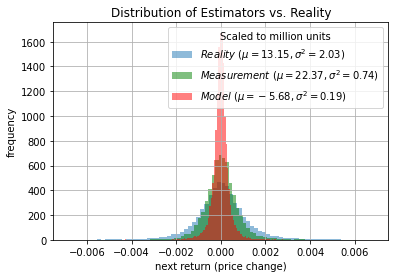

In [14]:
results['Reality'].hist(
    bins=300, alpha=0.5, density=True,
    label=r'$Reality\ (\mu={:.2f}, \sigma^2={:.2f})$'.format(
        results['Reality'].mean()*1000000, results['Reality'].var()*1000000))
results['Measurement'].hist(
    bins=300, alpha=0.5, color='green', density=True,
    label=r'$Measurement\ (\mu={:.2f}, \sigma^2={:.2f})$'.format(
        results['Measurement'].mean()*1000000, results['Measurement'].var()*1000000))
results['Prediction'].hist(
    bins=300, alpha=0.5, color='red', density=True,
    label=r'$Model\ (\mu={:.2f}, \sigma^2={:.2f})$'.format(
        results['Prediction'].mean()*1000000, results['Prediction'].var()*1000000))
plt.xlim([-0.0075, 0.0075])
plt.legend(title='Scaled to million units')
plt.title('Distribution of Estimators vs. Reality')
plt.xlabel('next return (price change)')
plt.ylabel('frequency')
plt.savefig('plots/histogram.png', dpi=300)
plt.show()

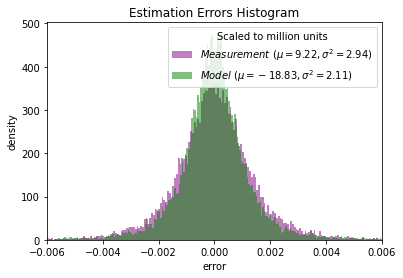

In [19]:
tmp = results['Measurement'] - results['Reality']
plt.hist(
    tmp,
    bins=1000, alpha=0.5, color='purple', density=True,
    label=r'$Measurement\ (\mu={:.2f}, \sigma^2={:.2f})$'.format(tmp.mean()*1000000, tmp.var()*1000000))

tmp = results['Prediction'] - results['Reality']
plt.hist(
    tmp,
    bins=1000, alpha=0.5, color='green', density=True,
    label=r'$Model\ (\mu={:.2f}, \sigma^2={:.2f})$'.format(tmp.mean()*1000000, tmp.var()*1000000))
plt.xlim([-0.006, 0.006])
plt.legend(title='Scaled to million units')
plt.title('Estimation Errors Histogram')
plt.xlabel('error')
plt.ylabel('density')
plt.savefig('plots/Error histogram.png', dpi=300)
plt.show()

In [115]:
# k = 255
# m = 60
# r = len(features.columns)
#
# results = pd.DataFrame(index=df.index)
# results['Prediction'] = None
# results['Measurement'] = None
#
# X = pd.DataFrame(index=df.index)
# for i in range(m+1):
#     X[f'Average Price Change from last {i} candle so far'] = \
#         df['Average Price'].pct_change(1 if i == 0 else i).shift(-1 if i == 0 else 0)
#
# # alpha = 1.05
# # W = np.diag(alpha ** np.arange(k) / np.sum(alpha ** np.arange(k)))
# # W = np.diag(np.arange(k) / np.sum(np.arange(k)))
#
# THETA = []
#
# period_start = datetime(2019, 12, 1)
# period_start_iloc = np.where(df.index == period_start)[0][0]
# period_end = datetime(2020, 1, 31)
# period_end_iloc = np.where(df.index == period_end)[0][0]
#
# for n in np.arange(period_start_iloc, period_end_iloc):
#     A = np.zeros([k, m+r])
#     A[:, m:m+r] = features.iloc[(n-2)-(k-1):(n-2)+1].to_numpy()
#     for i in range(m):
#         A[:, i] = df.iloc[(n-2)-(k-1)-i:(n-2)-i+1]['Average Price Change']
#     b = df.iloc[(n-1)-(k-1):(n-1)+1]['Real Return'].values
#     # theta, _, _, _ = np.linalg.lstsq(np.dot(W, A), np.dot(W, b), rcond=-1)
#     theta, _, _, _ = np.linalg.lstsq(A, b, rcond=-1)
#     THETA.append(theta)
#
#     prediction = np.dot(theta, np.concatenate([df.iloc[n-1:n-m-1:-1]['Real Return'].values,
#                                                df.iloc[n-1][[f'Feature {i+1}' for i in range(r)]].values]).ravel())
#     df.loc[df.index[n], 'Prediction'] = (1 + prediction / (100 * RETURN_SCALE)) * df.iloc[n-1]['Weighted Price Average']
#     df.loc[df.index[n], 'Measurement'] = df.iloc[n]['Open']
#
# df

In [10]:
indices = (df['Measurement'] - df['Weighted Price Average']).dropna().index

print(
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).var(),
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).var(),
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var()
)

df.loc[indices]

123.06694298085853 492.4141440553021 198.6163289608532


,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Weighted Price Average,Real Return,Prediction,Measurement
2020-01-04 00:00:00,7345.0,7350.00,7320.58,7330.83,418.917101,3074573.290919,3731,237.725142,1744694.439191,56.747538,44.553229,-0.664888,40.188679,35.300566,13.890554,7339.335834,16.422020,7347.756081,7345.0
2020-01-04 00:10:00,7330.83,7331.29,7315.72,7316.78,164.888036,1207308.260648,2024,81.797801,598915.347786,49.608087,-60.639459,-0.237919,77.634961,48.136305,16.521837,7321.988241,-23.636462,7343.780819,7330.83
2020-01-04 00:20:00,7316.58,7323.97,7309.38,7316.39,129.53026,947827.639843,1517,65.816654,481649.50508,50.811798,-21.443506,1.741051,82.742491,48.4926,16.594876,7317.422507,-6.235648,7296.818844,7316.58
2020-01-04 00:30:00,7316.97,7317.00,7289.98,7309.5,271.228827,1980347.532591,2655,132.694839,969073.185792,48.923575,109.394181,4.363111,67.477507,52.996486,17.885235,7301.390322,-21.909606,7314.828266,7316.97
2020-01-04 00:40:00,7309.5,7311.27,7290.80,7300.37,130.422169,952359.125111,1502,70.040453,511433.584821,53.702874,-51.914341,-0.448713,82.689104,60.035647,19.595101,7302.126106,1.007732,7309.46634,7309.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868,53.404983,70.100041,-3.843946,10.480641,41.901578,26.188374,8063.543117,29.024274,8047.747718,8042.26
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955,48.229204,-47.149644,0.421437,4.401325,37.697291,23.560706,8074.084912,13.073404,8125.094296,8066.72
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392,59.141497,224.837435,-3.41288,11.558162,19.718729,11.415279,8112.183537,47.186306,8079.294288,8078.0
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398,58.343097,90.925552,6.493125,18.736315,12.459266,7.42608,8172.891964,74.836112,8148.784292,8135.22


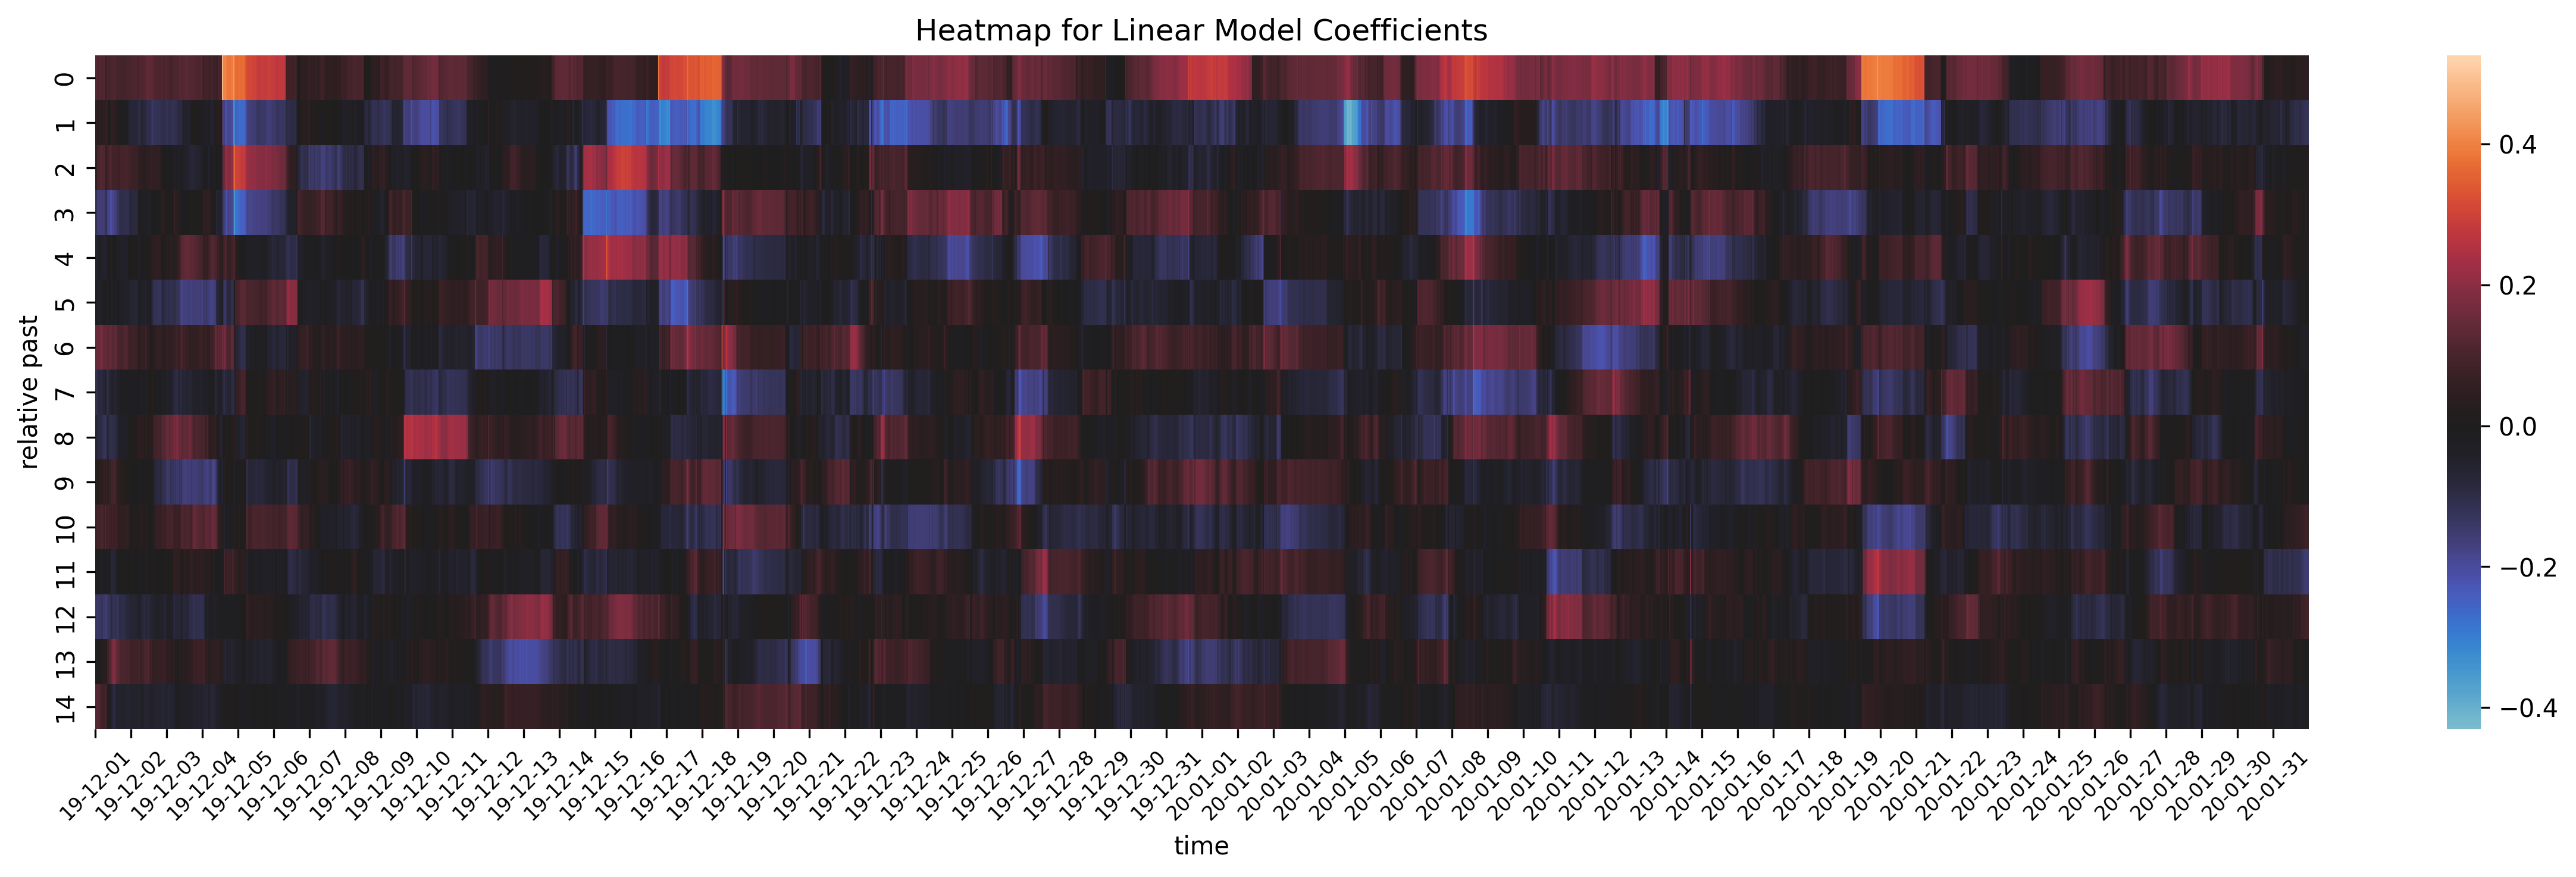

In [130]:
import seaborn as sns
plt.figure(figsize=(20, 5), dpi=300)
sns.heatmap(results[[f'{i}' for i in range(m)]].T, xticklabels=288, center=0)
plt.xticks(rotation=45, fontsize=8)
ticks = plt.xticks()
plt.xticks(ticks[0], ['{:s}'.format(i.get_text()[2:10]) for i in ticks[1]])
plt.xlabel('time')
plt.ylabel('relative past')
plt.title('Heatmap for Linear Model Coefficients')
plt.savefig('plots/heatmap for theta.png')
plt.show()

# Linear Model with Control

In [152]:
features = pd.DataFrame(index=df.index)
features['taker buy volume ratio'] = df['Taker Buy Volume'] / (df['Volume'] + EPSILON)
features['volume (1e3)'] = df['Volume'] / 1000
features['volume change'] = (df['Volume'] + EPSILON).pct_change()
features['trades number (1e3)'] = df['No. Trades'] / 1000
features['trades number change'] = (df['No. Trades'] + EPSILON).pct_change()
features['taker buy average spread (1e-3)'] = ((df['Taker Buy Value'] / df['Taker Buy Volume']) / df['Average Price'] - 1) * 1000
features['taker sell average spread (1e-3)'] = (((df['Value'] - df['Taker Buy Value']) / (df['Volume'] - df['Taker Buy Volume'])) / df['Average Price'] - 1) * 1000
features_means, features_stds = features.mean(), features.std()
# features = (features - features_means) / features_stds
print('Multipliers:')
print(features_stds)
features

Multipliers:
taker buy volume ratio              0.117385
volume (1e3)                        0.216498
volume change                       1.169388
trades number (1e3)                 1.307676
trades number change                0.631815
taker buy average spread (1e-3)     0.123620
taker sell average spread (1e-3)    0.125850
dtype: float64


,taker buy volume ratio,volume (1e3),volume change,trades number (1e3),trades number change,taker buy average spread (1e-3),taker sell average spread (1e-3)
2019-11-27 00:00:00,0.631978,0.1642,NaN,1.234,NaN,0.095183,-0.163451
2019-11-27 00:05:00,0.635365,0.115532,-0.296398,0.904,-0.267423,0.05407,-0.094216
2019-11-27 00:10:00,0.507273,0.11278,-0.023816,0.914,0.011062,0.124325,-0.127995
2019-11-27 00:15:00,0.446718,0.157904,0.400103,0.833,-0.088621,-0.002534,0.002046
2019-11-27 00:20:00,0.5856,0.071999,-0.544030,0.638,-0.234094,0.056861,-0.080352
...,...,...,...,...,...,...,...
2020-02-03 23:35:00,0.557644,0.148544,1.582849,1.348,0.829037,0.037126,-0.046801
2020-02-03 23:40:00,0.713958,0.090221,-0.392631,0.908,-0.326409,-0.008885,0.022178
2020-02-03 23:45:00,0.486972,0.139876,0.550373,1.874,1.063877,0.046432,-0.044074
2020-02-03 23:50:00,0.47567,0.095825,-0.314930,1.331,-0.289755,-0.005927,0.005377


In [153]:
m = 15
k = 511
r = len(features.columns)

X = pd.DataFrame(index=df.index)
for i in range(m):
    X[f'Average Price Change from last {i} candle so far'] = \
        df['Average Price'].pct_change(1 if i == 0 else i).shift(-1 if i == 0 else 0)

period_start = datetime(2019, 12, 1)
period_start_iloc = np.where(df.index == period_start)[0][0]
period_end = datetime(2020, 2, 1)
period_end_iloc = np.where(df.index == period_end)[0][0]

THETA = []
results = pd.DataFrame(index=df.index)
results['Prediction'] = None
results['Measurement'] = None
results['Model Noise Bias'] = None
for n in np.arange(period_start_iloc, period_end_iloc):
    A = np.zeros([k, m+r])
    A[:, range(m)] = X.iloc[(n-2)-(k-1):(n-2)+1].to_numpy()
    A[:, range(m, m+r)] = features.iloc[(n-1)-(k-1):(n-1)+1]
    b = X.iloc[(n-1)-(k-1):(n-1)+1, 0].values
    theta, _, _, _ = np.linalg.lstsq(A, b, rcond=-1)
    THETA.append(theta)
    pos = results.index[n]
    results.loc[pos, 'Model Noise Bias'] = (np.dot(A, theta) - b).mean()
    results.loc[pos, 'Prediction'] = np.dot(theta[0:m], X.iloc[n-1].values) +\
                                     np.dot(theta[m:m+r], features.iloc[n].values) +\
                                     results.loc[pos, 'Model Noise Bias']
    results.loc[pos, 'Measurement'] = df.iloc[n]['Open'] / df.iloc[n-1]['Average Price'] - 1

indices = df.index[period_start_iloc:period_end_iloc]
results = results.loc[indices]
results['Reality'] = df['Average Price Change'].shift(-1).loc[indices].values
THETA = pd.DataFrame(THETA, index=indices)
pd.concat([results, THETA], axis=1).to_csv(f'data/linear_model_with_control[k={k},m={m}]')

t = np.bincount(np.sign(results['Prediction']) == np.sign(results['Reality']))
print(t[1] / (t[0]+t[1]) * 100)
print('STANDARD ERRORS')
for c_label in ['Prediction', 'Measurement']:
    print('  > {:13s}{:.5f}'.format(c_label + ':', (results[c_label] - results['Reality']).std()))
print('  > {:13s}{:.5f}'.format('Reality:', (results['Reality']-df['Average Price Change'].loc[indices].values).std()))

52.59856630824373
STANDARD ERRORS
  > Prediction:  0.00149
  > Measurement: 0.00171
  > Reality:     0.00186


In [155]:
THETA

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
2019-12-01 00:00:00,0.083256,0.059598,0.033870,-0.106701,-0.057984,-0.002032,0.126400,-0.107511,-0.052049,0.020379,...,-0.139606,0.007428,0.105871,0.000877,0.005730,-0.000062,-0.001101,0.000081,-0.000182,0.000637
2019-12-01 00:05:00,0.083507,0.059063,0.033260,-0.105626,-0.058569,-0.001170,0.125658,-0.107419,-0.052463,0.020811,...,-0.139894,0.007055,0.106414,0.000876,0.005733,-0.000061,-0.001102,0.000081,-0.000200,0.000625
2019-12-01 00:10:00,0.085377,0.062108,0.031340,-0.107404,-0.054969,-0.003230,0.129756,-0.110909,-0.051861,0.019010,...,-0.139243,0.004558,0.108022,0.000867,0.005740,-0.000075,-0.001102,0.000091,-0.000168,0.000644
2019-12-01 00:15:00,0.085424,0.062296,0.031513,-0.107384,-0.055598,-0.002700,0.129340,-0.110225,-0.052482,0.018863,...,-0.139414,0.004269,0.108287,0.000865,0.005713,-0.000075,-0.001096,0.000090,-0.000176,0.000648
2019-12-01 00:20:00,0.085929,0.064449,0.031951,-0.106431,-0.057479,-0.001503,0.130522,-0.109464,-0.053169,0.018921,...,-0.139893,0.005295,0.107974,0.000866,0.005761,-0.000080,-0.001110,0.000107,-0.000164,0.000617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.071350,-0.129127,0.009263,-0.003783,-0.008132,0.019355,0.001458,-0.013225,-0.036150,0.017149,...,0.075648,-0.007254,-0.000922,0.001136,0.004604,-0.000287,-0.000807,0.000408,0.000471,0.001906
2020-01-31 23:40:00,0.071982,-0.128932,0.009459,-0.003679,-0.007901,0.018658,0.001482,-0.014630,-0.034795,0.016182,...,0.076883,-0.007369,-0.001059,0.001145,0.004633,-0.000293,-0.000813,0.000429,0.000487,0.001928
2020-01-31 23:45:00,0.074024,-0.137809,0.009597,-0.002333,-0.006089,0.026361,-0.006383,-0.013876,-0.040701,0.020661,...,0.076680,-0.011026,0.000223,0.001142,0.004667,-0.000290,-0.000818,0.000424,0.000518,0.001941
2020-01-31 23:50:00,0.077746,-0.138638,0.009375,-0.002276,-0.005767,0.027313,-0.005867,-0.015246,-0.041607,0.018004,...,0.077295,-0.010840,0.001214,0.001160,0.004762,-0.000302,-0.000834,0.000428,0.000569,0.001956


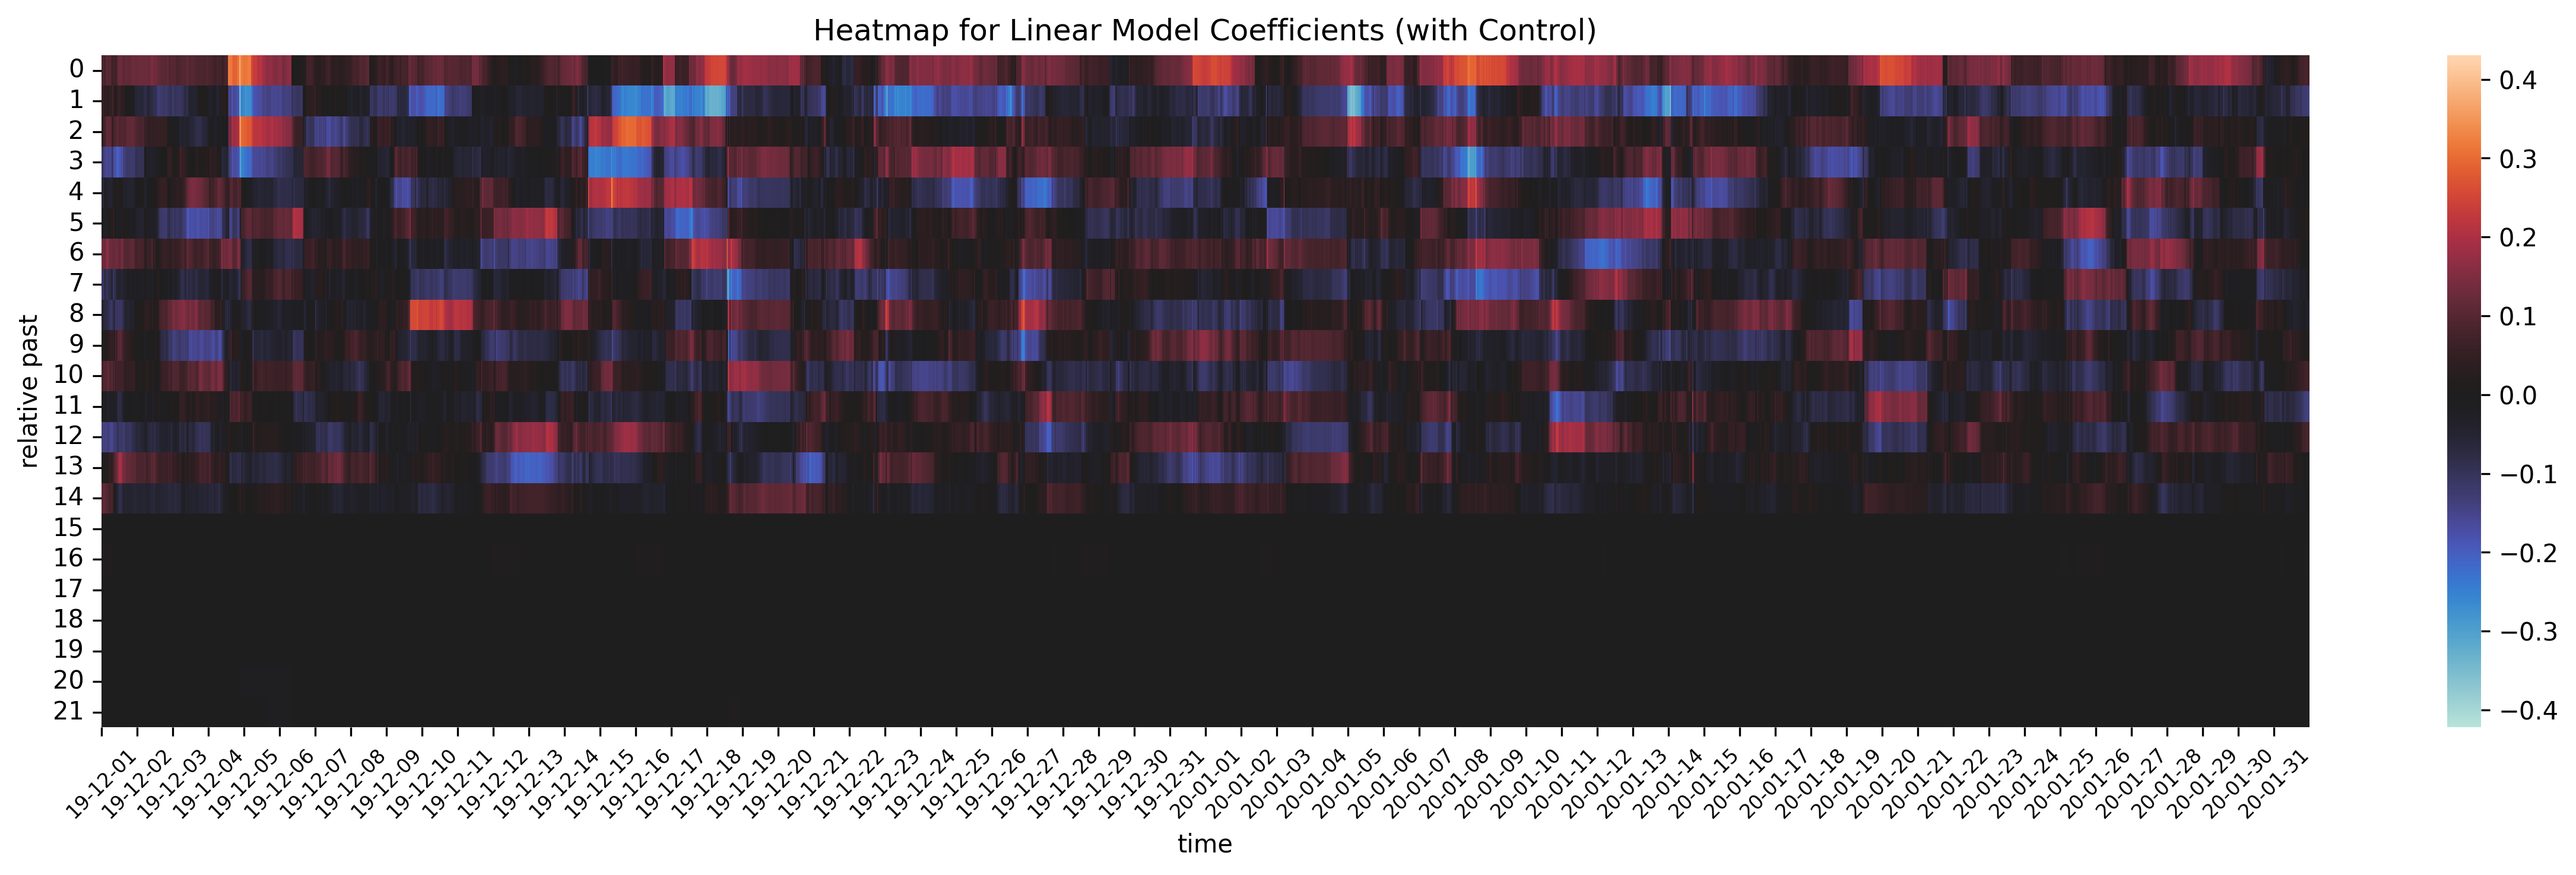

In [154]:
import seaborn as sns
plt.figure(figsize=(20, 5), dpi=300)
sns.heatmap(THETA.T, xticklabels=288, center=0)
plt.xticks(rotation=45, fontsize=8)
ticks = plt.xticks()
plt.xticks(ticks[0], ['{:s}'.format(i.get_text()[2:10]) for i in ticks[1]])
plt.xlabel('time')
plt.ylabel('relative past')
plt.title('Heatmap for Linear Model Coefficients (with Control)')
plt.savefig('plots/heatmap for theta (control).png')
plt.show()

In [13]:
df['Measurement Residual'] = df['Measurement'] - df['Weighted Price Average']
df['Prediction Residual'] = df['Prediction'] - df['Weighted Price Average']
df['Measurement Residual Weighted Variance'] = df['Measurement Residual'].rolling(12).var()
df['Prediction Residual Weighted Variance'] = df['Prediction Residual'].rolling(6).var()
df['Kalman Gain'] = df['Prediction Residual Weighted Variance'] / \
                    (df['Measurement Residual Weighted Variance'] + df['Prediction Residual Weighted Variance'])
df['Estimate'] = df['Kalman Gain'] * df['Measurement'] + (1 - df['Kalman Gain']) * df['Prediction']
df['Estimate Uncertainty'] = df['Kalman Gain'] ** 2 * df['Measurement Residual Weighted Variance'] + \
                             (1 - df['Kalman Gain']) ** 2 * df['Prediction Residual Weighted Variance']
df.loc[indices]

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,...,Real Return,Prediction,Measurement,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2020-01-04 00:00:00,7345.0,7350.00,7320.58,7330.83,418.917101,3074573.290919,3731,237.725142,1744694.439191,56.747538,...,16.422020,7347.756081,7345.0,5.664166,8.420247,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:10:00,7330.83,7331.29,7315.72,7316.78,164.888036,1207308.260648,2024,81.797801,598915.347786,49.608087,...,-23.636462,7343.780819,7330.83,8.841759,21.792578,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:20:00,7316.58,7323.97,7309.38,7316.39,129.53026,947827.639843,1517,65.816654,481649.50508,50.811798,...,-6.235648,7296.818844,7316.58,-0.842507,-20.603663,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:30:00,7316.97,7317.00,7289.98,7309.5,271.228827,1980347.532591,2655,132.694839,969073.185792,48.923575,...,-21.909606,7314.828266,7316.97,15.579678,13.437943,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:40:00,7309.5,7311.27,7290.80,7300.37,130.422169,952359.125111,1502,70.040453,511433.584821,53.702874,...,1.007732,7309.46634,7309.5,7.373894,7.340234,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868,53.404983,...,29.024274,8047.747718,8042.26,-21.283117,-15.795399,447.789899,4167.936517,0.902986,8042.792385,404.348027
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955,48.229204,...,13.073404,8125.094296,8066.72,-7.364912,51.009384,415.953939,2760.304970,0.869043,8074.364534,361.481780
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392,59.141497,...,47.186306,8079.294288,8078.0,-34.183537,-32.889248,510.200855,2431.515391,0.826564,8078.224477,421.713424
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398,58.343097,...,74.836112,8148.784292,8135.22,-37.671964,-24.107672,593.036108,1479.582776,0.713871,8139.101136,423.351354


In [14]:
%matplotlib notebook

plt.xticks(rotation=90)
plt.plot(
    indices,
    df.loc[indices, 'Weighted Price Average'],
    color='black'
)

# plot measurement errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Measurement'],
    color='red'
)
plt.scatter(
    indices,
    df.loc[indices, 'Measurement'],
    color='red'
)

# plot model approximation errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Prediction'],
    color='blue'
)
plt.scatter(
    indices,
    df.loc[indices, 'Prediction'],
    color='blue'
)

# plot model approximation errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Estimate'],
    color='green'
)
plt.scatter(
    indices,
    df.loc[indices, 'Estimate'],
    color='green',
    marker='x'
)
plt.show()

<IPython.core.display.Javascript object>

c:\users\torobcheh\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\users\torobcheh\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


In [15]:
print(
    "Measurement:\t",
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n Prediction:\t",
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n   Estimate:\t",
    (df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).std(),
    "   R_square:",
    1 - (df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).var() /
        (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var(),
    "\n   Base std:\t",
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).std()
)

Measurement:	 11.093554118534714 
 Prediction:	 22.190406577061676 
   Estimate:	 11.472527263090491    R_square: 0.3373209418834019 
   Base std:	 14.09313055927792


In [16]:
# from scipy.stats import pearsonr
# result = []
# data = df.dropna().copy()
# data = data[(data['Feature 2'] >= 3) & (data['No. Trades'] > 100)]
# for i in range(period):
#     for j in range(4):
#         result.append(pearsonr(data[f'Return {i+1} min'], data[f'Feature {j+1}']))
# result = np.array(result)
# result = result.reshape(-1, 8)
# for j in range(4):
#     plt.plot(result[:, 2*j], label=f'Feature {j+1}')
# plt.legend()
# plt.title(f'n = {len(data)}')
# plt.show()

In [17]:
# t_train_start = datetime(2018, 1, 1, 1)
# t_train_duration = timedelta(hours=6)
# x_train = x.loc[t_train_start:t_train_start+t_train_duration-timedelta(minutes=1)]
# A =

In [18]:
indices = df.dropna().index
df['Volume Change'] = df.Volume.pct_change() * 100
indices = df.loc[indices].loc[(df.loc[indices, 'Volume Change'] >= 0) &
                              (np.sqrt(df.loc[indices, 'Estimate Uncertainty']) < 20)].index

print(
    "Measurement:\t",
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n Prediction:\t",
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n   Estimate:\t",
    (df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).std(),
    "   R_square:",
    1 - np.sqrt((df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).var() /
        (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var()),
    "\n   Base std:\t",
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).std()
)

Measurement:	 13.334839260567822 
 Prediction:	 18.8171861654 
   Estimate:	 13.376925728125698    R_square: 0.1593659284243888 
   Base std:	 15.912899774634583
